In [1]:
!git clone https://github.com/Mike030668/Project_glass.git -q
!pip install backtesting -q

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 175.5/175.5 kB 1.6 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [2]:
if 'google.colab' in str(get_ipython()):
  print('Running on CoLab')
  import os
  os.chdir('/content/Project_glass')
  os.getcwd()

else:
  print('Not running on CoLab')

Running on CoLab


In [3]:
# модули и функции проекта glass
from prepare_data.constants import GLASS_COLS, FUTURE, MAIN_COLS, DEPTH, PREDICT_LAG, BATCH_SIZE, MAKE_LOG_VOL
from prepare_data.const_predprice import  TARGET_COLS, BASE_COLS, MAKE_LOG_TARGET
from prepare_data.utils import future_sequence, split_sequence, clean_dataset
from scripts.bots import cond_long, cond_short, long_Short
from scripts.robotest import prepare_data, making_signals
from scripts.stratagy import Reverse_Strategy

from backtesting import Backtest # Библиотеки backtesting
import tensorflow as tf  # библиотека машинного обучения
import pandas as pd # библиотека пандас
import numpy as np # библиотека нампи
import joblib
from tqdm.notebook import tqdm   # отрисовка прохождения цикла
import warnings # библиотека сообщений по ошибкам
warnings.filterwarnings("ignore") # игнорировать сообщения ошибок

/usr/local/lib/python3.10/dist-packages/backtesting/_plotting.py:50: UserWarning: Jupyter Notebook detected. Setting Bokeh output to notebook. This may not work in Jupyter clients without JavaScript support (e.g. PyCharm, Spyder IDE). Reset with `backtesting.set_bokeh_output(notebook=False)`.
  warnings.warn('Jupyter Notebook detected. '


## Готовим производные данных

In [4]:
all_data = pd.read_csv("/content/Project_glass/stock_data/BTCUSDT_1 _min.csv",
                       index_col=0, parse_dates=True )
print(f'Размер данных {all_data.shape}')

Размер данных (8317, 54)


In [5]:
# колонки для тренировочной выборки сетки тренда
TREND_PRED_COLS = MAIN_COLS + GLASS_COLS

# колонки для тренировочной выборки сетки цены
PRICE_PRED_COLS = BASE_COLS + GLASS_COLS

# N колонки где начинается стакан
GLASS = len(GLASS_COLS)

In [6]:
# сетки
trend_model =  tf.keras.models.load_model('./predtrend/model')
price_model =  tf.keras.models.load_model('./predprice/model')

# скейлеры для сетки тренда
x_trend_main_scr = joblib.load("/content/Project_glass/predtrend/x_main_scailer.save")
x_trend_glass_scr = joblib.load("/content/Project_glass/predtrend/x_glass_scailer.save")
trend_scalers = [x_trend_main_scr, x_trend_glass_scr]
# скейлеры для сетки цены
x_price_main_scr = joblib.load("/content/Project_glass/predprice/x_main_scailer.save")
x_price_glass_scr = joblib.load("/content/Project_glass/predprice/x_glass_scailer.save")
y_price_scr = joblib.load("/content/Project_glass/predprice/y_scailer.save")
price_scalers = [x_price_main_scr, x_price_glass_scr, y_price_scr]

# Пример теста 2-го бота по ТЗ

- Вход лонг:

      Покупаем когда текущая позиция 0 или Шорт- (если ничего не куплено, это первая сделка то покупаем 100.
      Если были в шорте то покупаем 200 для разворота позиции) И
      Сетка 2 изменила состояние Флэт или Падение на Рост по всем пяти минутам

- Выход из лонга сразу Вход шорт:

      Продаем когда текущая позиция Куплено И :
      Сетка 2 изменила состояние Флэт или Рост на Падение по всем пяти минутам.

In [8]:
FUTURE = 3000

# длина взгляда назад
BACK = DEPTH + PREDICT_LAG
TEST_SIZE = 3000
# данные назад
past_data =  all_data[FUTURE-BACK : FUTURE - PREDICT_LAG].copy()

# тестируемы датафрейм
test_data = all_data[FUTURE-PREDICT_LAG : FUTURE + TEST_SIZE].copy()

# получаем датафрейм с сигналом
df_test_signal = making_signals(past_data,
                                test_data,

                                # функция управления с сигналом по индексам
                                fun_action = long_Short(
                                          action = "mix",      # mix = long_Short
                                          # long индексы [0,1,2,3,4]
                                          lg_id_pr_up = [], # id предсказаний выше текущей цены
                                          lg_id_tr_up = [0], # Рост по id
                                          lg_id_pr_lw = [], # id предсказаний ниже текущей цены
                                          lg_id_tr_lw = [], # Падение по id
                                          # short индексы [0,1,2,3,4]
                                          sh_id_pr_up = [], # id предсказаний выше текущей цены
                                          sh_id_tr_up = [], # Рост по id
                                          sh_id_pr_lw = [], # id предсказаний ниже текущей цены
                                          sh_id_tr_lw = [0], # Падение по id
                                          # приземляем ли предсказание и как
                                          correct_price = False
                                ),

                                pred_lag = PREDICT_LAG,
                                glass = GLASS,
                                depth = DEPTH,
                                make_log_vol = MAKE_LOG_VOL,
                                make_log_tgt = MAKE_LOG_TARGET,
                                model_price = price_model,
                                model_trend = trend_model,
                                scalers_price = price_scalers,
                                scalers_trend = trend_scalers,
                                features_price = PRICE_PRED_COLS,
                                features_trend = TREND_PRED_COLS,
                                show_unique_signals = True
                                )

Пробегаемся по всем отсчетам:   0%|          | 0/3000 [00:00<?, ?step/s]

[-1, 0]
[-1, 0]
[-1, 0]
[-1, 0]
[-1, 0]
[-1, 0]
[0, 1]
[0, 1]
[-1, 0]
[0, 1]
[-1, 0]
[-1, 0]
[-1, 0]
[-1, 0]
[-1, 0]
[-1, 0]
[-1, 0]
[-1, 0]
[-1, 0]
[0, 1]
[-1, 0]
[-1, 0]
[0, 1]
[0, 1]
[-1, 0]
[-1, 0]
[0, 1]
[0, 1]
[-1, 0]
[-1, 0]
[-1, 0]
[-1, 0]
[-1, 0]
[-1, 0]
[0, 1]
[0, 1]
[0, 1]
[0, 1]
[-1, 0]
[-1, 0]
[-1, 0]
[-1, 0]
[-1, 0]
[-1, 0]
[-1, 0]
[-1, 0]
[0, 1]
[0, 1]
[-1, 0]
[0, 1]
[-1, 0]
[-1, 0]
[-1, 0]
[0, 1]
[-1, 0]
[-1, 0]
[0, 1]
[-1, 0]
[-1, 0]
[-1, 0]
[0, 1]
[-1, 0]
[-1, 0]
[-1, 0]
[-1, 0]
[-1, 0]
[-1, 0]
[-1, 0]
[-1, 0]
[0, 1]
[-1, 0]
[-1, 0]
[-1, 0]
[-1, 0]
[0, 1]
[-1, 0]
[-1, 0]


## Совмещенный график предсказаний



In [14]:
np.unique(y_pred_trend)

array([-1,  0,  1])

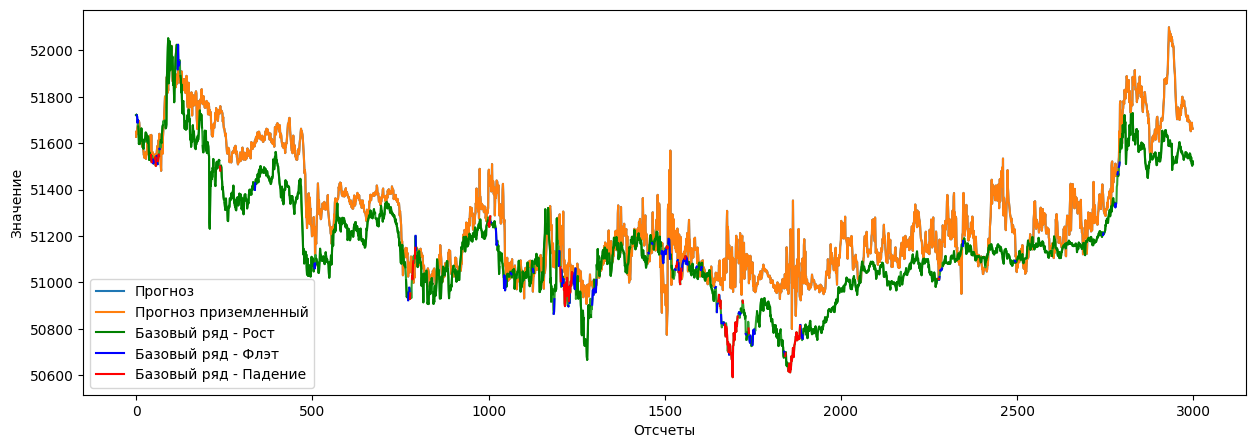

In [10]:
import matplotlib.pyplot as plt # библиотека матплотлиб для отрисовки
y_pred_earth = df_test_signal["pred_earth_price"].astype(float).to_numpy()
y_pred = df_test_signal["pred_price"].astype(float).to_numpy()
y_true = df_test_signal["Close"].to_numpy()

# pred_trend
y_pred_trend = df_test_signal["pred_trend"].astype(int).to_numpy()
down = (y_pred_trend == -1)
flat = (y_pred_trend == 0)
gross = (y_pred_trend == 1)

# смещаем на 1 вперед чтобы совместить педсказания завтра с реальной ценой на завтра
plt.figure(figsize=(15,5))
plt.plot(y_pred[1:], label=f'Прогноз')
plt.plot(y_pred_earth[1:], label=f'Прогноз приземленный')


plt.plot(y_true)
plt.plot(np.where(gross, y_true, None), color="green", label= 'Базовый ряд - Рост')
plt.plot(np.where(flat, y_true, None), color="blue", label= 'Базовый ряд - Флэт')
plt.plot(np.where(down, y_true, None), color="red", label= 'Базовый ряд - Падение')

plt.xlabel('Отсчеты')
plt.ylabel(f'Значение')
plt.legend()
plt.show()


# Backtest

## Reverse_Strategy

In [17]:
CAPITAL = 100000
COMIS = 0.0002
# Стратегия Reverse_Strategy
bt = Backtest(df_test_signal, Reverse_Strategy, cash= CAPITAL, commission=COMIS,
              hedging = True, trade_on_close=False,  exclusive_orders=True)
stats = bt.run()
bt.plot(plot_volume=True, relative_equity=True)
stats

Start                     2024-02-22 19:00:00
End                       2024-02-24 21:06:00
Duration                      2 days 02:06:00
Exposure Time [%]                         0.0
Equity Final [$]                     100000.0
Equity Peak [$]                      100000.0
Return [%]                                0.0
Buy & Hold Return [%]               -0.406021
Return (Ann.) [%]                         0.0
Volatility (Ann.) [%]                     0.0
Sharpe Ratio                              NaN
Sortino Ratio                             NaN
Calmar Ratio                              NaN
Max. Drawdown [%]                        -0.0
Avg. Drawdown [%]                         NaN
Max. Drawdown Duration                    NaN
Avg. Drawdown Duration                    NaN
# Trades                                    0
Win Rate [%]                              NaN
Best Trade [%]                            NaN
Worst Trade [%]                           NaN
Avg. Trade [%]                    